In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv


In [2]:
import pandas as pd
import numpy as np
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
import re
import multiprocessing
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
col_names = ["target", "ids", "date", "flag", "user", "text"]
df = pd.read_csv('../input/sentiment140/training.1600000.processed.noemoticon.csv',encoding = "ISO-8859-1",
            names=col_names)
df=df.sample(100000)

In [5]:
df.tail()

,target,ids,date,flag,user,text
316941,0,2002502568,Tue Jun 02 04:24:07 PDT 2009,NO_QUERY,RHCPfan24,What's the first conference today and at what ...
804697,4,1468556282,Tue Apr 07 02:23:38 PDT 2009,NO_QUERY,startupz,@Jeicky_the_cat @skwi69 Thanks
1157359,4,1979173746,Sun May 31 01:56:10 PDT 2009,NO_QUERY,Cairo_,with me. I think we sang trainwreck.
1205980,4,1986691818,Sun May 31 19:11:07 PDT 2009,NO_QUERY,VRSantizo,wants to see andy samberg's version of new moon!
939270,4,1793637404,Thu May 14 03:27:17 PDT 2009,NO_QUERY,NicolaWwilts,@KevinSpacey Can I get a little hello ? ...wou...


## Dataset Preprocessing

In [6]:
df.target.value_counts()

4    50436
0    49564
Name: target, dtype: int64

In [7]:
df.isna().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [8]:
df.flag.value_counts()

NO_QUERY    100000
Name: flag, dtype: int64

In [9]:
df['target']=df['target'].replace(4,1) 

In [10]:
df['text'].iat[-2]

"wants to see andy samberg's version of new moon! "

In [11]:
data = df['text']
labels = np.array(df['target'])

## Text Preprocessing


In [12]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)
def tweet(words):
    tweet_tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True,reduce_len=True)
    tweet = tweet_tokenizer.tokenize(words)
    return tweet
        

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)
data = data.apply(denoise_text)

In [13]:
data.head()

971266              im msn aim lets chat send screenamesmsns
1213399    ddlovato hahahha demi youre awesome love youre...
838952                               hi im aries yu make one
264863                                        gcses cooooome
685793     awh im jealous suppose mountain bar amp grands...
Name: text, dtype: object

In [14]:
print('Text Before: {}'. format(''.join(df['text'].iat[-1])))
print('Text After: {}'. format(''.join(data.iat[-1])))

Text Before: @KevinSpacey Can I get a little hello ? ...would make me smile , oh I am creeping ,WELL JUST FOR YOU I DO  
Text After: kevinspacey get little hello would make smile oh creeping well


In [15]:
TRAIN_SIZE = 0.8
MAX_NB_WORDS = 100000
MAX_SEQUENCE_LENGTH = 30

In [16]:
X_train, X_test,y_train,y_test = train_test_split(data,labels, test_size=1-TRAIN_SIZE,random_state=7) 
print("Train Data size:", len(X_train))
print("Test Data size", len(y_train))

Train Data size: 80000
Test Data size 80000


## Tokenization

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 81913


In [18]:
X_train = pad_sequences(tokenizer.texts_to_sequences(X_train),
                        maxlen = MAX_SEQUENCE_LENGTH)
X_test = pad_sequences(tokenizer.texts_to_sequences(X_test),
                       maxlen = MAX_SEQUENCE_LENGTH)

print("Training X Shape:",X_train.shape)
print("Testing X Shape:",X_test.shape)

Training X Shape: (80000, 30)
Testing X Shape: (20000, 30)


In [19]:
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

y_train shape: (80000, 1)
y_test shape: (20000, 1)


## Word Emdedding 

In [20]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2023-01-14 19:48:12--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-01-14 19:48:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-01-14 19:48:12--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [21]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 1024
EPOCHS = 10
MODEL_PATH = '.../output/kaggle/working/best_model.hdf5'

In [22]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
  values = line.split()
  word = value = values[0]
  coefs = np.asarray(values[1:], dtype='float32')
  embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [23]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector

In [24]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                          EMBEDDING_DIM,
                                          weights=[embedding_matrix],
                                          input_length=MAX_SEQUENCE_LENGTH,
                                          trainable=False)

## Model Training

In [25]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)
x = SpatialDropout1D(0.2)(embedding_sequences)
x = Conv1D(64, 5, activation='relu')(x)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, outputs)

2023-01-14 19:51:36.014248: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 19:51:36.015152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 19:51:36.147598: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 19:51:36.148507: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 19:51:36.149346: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [27]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy',
              metrics=['accuracy'])
ReduceLROnPlateau = ReduceLROnPlateau(factor=0.1,
                                     min_lr = 0.01,
                                     monitor = 'val_loss',
                                     verbose = 1)

In [28]:
print("Training on GPU...") if tf.test.is_gpu_available() else print("Training on CPU...")

Training on GPU...


2023-01-14 19:51:40.371129: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 19:51:40.371771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 19:51:40.372537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 19:51:40.372959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-14 19:51:40.373661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [29]:
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_test, y_test), callbacks=[ReduceLROnPlateau])

2023-01-14 19:51:40.544771: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2023-01-14 19:51:46.503739: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


79/79 [==============================] - 37s 305ms/step - loss: 0.5933 - accuracy: 0.6781 - val_loss: 0.5379 - val_accuracy: 0.7266
Epoch 2/10
79/79 [==============================] - 23s 291ms/step - loss: 0.5374 - accuracy: 0.7255 - val_loss: 0.5171 - val_accuracy: 0.7416
Epoch 3/10
79/79 [==============================] - 24s 301ms/step - loss: 0.5137 - accuracy: 0.7429 - val_loss: 0.5061 - val_accuracy: 0.7523
Epoch 4/10
79/79 [==============================] - 24s 308ms/step - loss: 0.4934 - accuracy: 0.7591 - val_loss: 0.5037 - val_accuracy: 0.7542
Epoch 5/10
79/79 [==============================] - 24s 307ms/step - loss: 0.4767 - accuracy: 0.7694 - val_loss: 0.5028 - val_accuracy: 0.7538
Epoch 6/10
79/79 [==============================] - 23s 291ms/step - loss: 0.4616 - accuracy: 0.7806 - val_loss: 0.4996 - val_accuracy: 0.7536
Epoch 7/10
79/79 [==============================] - 24s 299ms/step - loss: 0.4454 - accuracy: 0.7903 - val_loss: 0.5066 - val_accuracy: 0.7516
Epoch 8/10

## Model Evaluation

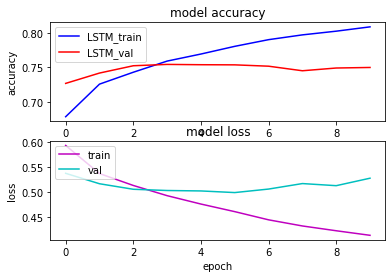

In [30]:
s, (at, al) = plt.subplots(2,1)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

In [31]:
def decode_sentiment(score):
    return "Positive" if score>0.5 else "Negative"

In [32]:
scores = model.predict(X_test, verbose=1, batch_size=10000)
y_pred_1d = [decode_sentiment(score) for score in scores]

2/2 [==============================] - 1s 63ms/step


In [33]:
Y_test=[decode_sentiment(x) for x in y_test]

In [34]:
print(classification_report(Y_test, y_pred_1d))

              precision    recall  f1-score   support

    Negative       0.77      0.71      0.73      9812
    Positive       0.74      0.79      0.76     10188

    accuracy                           0.75     20000
   macro avg       0.75      0.75      0.75     20000
weighted avg       0.75      0.75      0.75     20000



In [35]:
def predict_text(text, include_neutral=True):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=MAX_SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)
    if label=="Negative":
        score+=0.5
    print("label: ", label)
    print("score: ", float(score))

In [36]:
ep="Wtf it's so nice out!we should go to celebrate"
predict_text(ep)

label:  Positive
score:  0.6383631229400635
